In [2]:
import sv_utils
import torch 
import numpy as np
import pylab as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure
from os.path import dirname, realpath
from singleNeuron import preSpikes, nextSpikes, STDPLIFDensePopulation, convergence_level

## Sequence Visualizer

El proposito de esta notebook es el poder graficar tanto la entrada como salida de la red DSNN que reconoce patrones en una secuencia de numeros aleatorios.

In [3]:
Sin_tmp = np.load('./sequences/all_nums/all_nums.npy')
print(Sin_tmp.shape)
Sin = np.reshape(Sin_tmp, (Sin_tmp.shape[0]*Sin_tmp.shape[1], Sin_tmp.shape[2]))
Sin = np.transpose(Sin)
print(Sin.shape)

(34, 34, 37485)
(37485, 1156)


### Tren de spikes de entrada

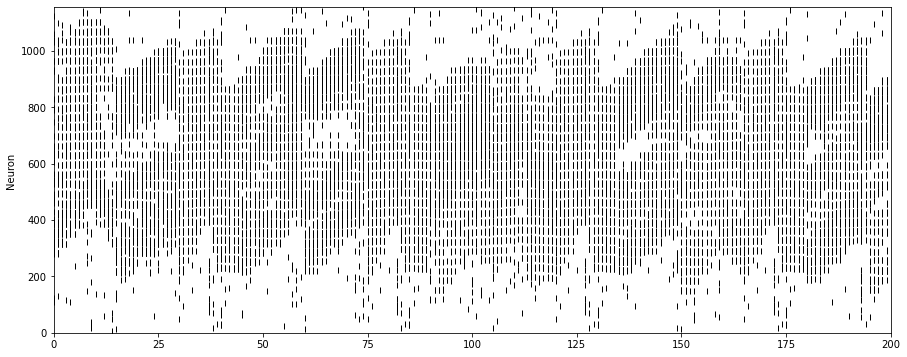

Spikes: 3579729


In [4]:
plt.rcParams["figure.figsize"] =(15,6)
sv_utils.plotLIF(U=None, S=Sin[:200])
print("Spikes: " + str(np.count_nonzero(Sin)))

### Tren de spikes de salida 

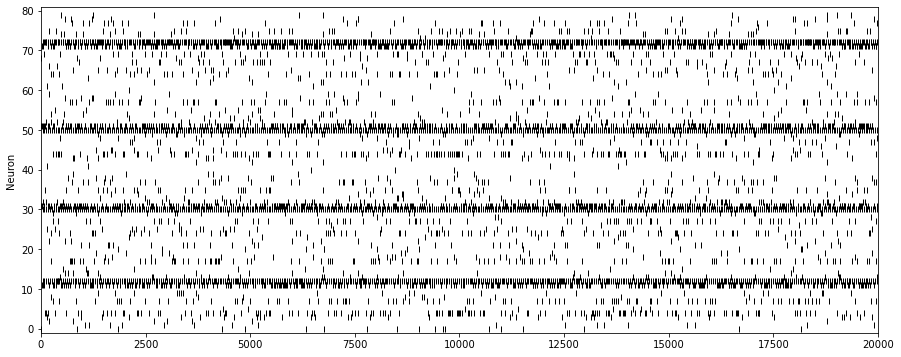

torch.Size([37485, 80])
Spikes: 10027


In [5]:
Sin_out_s = torch.load('../cleanDSNN/results/old_results/all_nums/layer_5_conv.pt')
sv_utils.plotLIF(U=None, S=Sin_out_s[:20000].data.numpy())
print(Sin_out_s.shape)
print("Spikes: " + str(np.count_nonzero(Sin_out_s)))

## Entrenamos a la neurona de salida

In [7]:
pat_times = np.load('./sequences/all_nums/pat_all_nums.npy')
Sin_tmp = Sin_out_s.clone().detach()
T = Sin_tmp.shape[0]
N_out = 1
N_in = Sin_tmp.shape[1]
th = 3.5

singleNeuron = STDPLIFDensePopulation(in_channels=N_in, out_channels=N_out,
                                        weight=0.75, alpha=float(np.exp(-1e-3/10e-3)),
                                        beta=float(np.exp(-1e-3/2e-5)), delay=0,
                                        th=th, a_plus=.03125, a_minus=.045625,
                                        w_max=1.)
Sin = Sin_tmp.clone().detach()

# Pre-procesamos PSpikes y NSpikes
dt_ltp = 20  # Cantidad de timesteps que miro hacia atras
dt_ltd = 70  # Cantidad de timesteps que miro hacia delante
PSpikes = preSpikes(T, dt_ltp, torch.zeros(T, N_in), Sin)
NSpikes = nextSpikes(T, dt_ltd, torch.zeros(T, N_in), Sin)

# Realizamos el entrenamiento STDP
Uprobe = np.empty([T, N_out])
Iprobe = np.empty([T, N_out])
Sprobe = np.empty([T, N_out])

n = 0
t = 0
c_l = 1.
while (c_l > 0.01) and (t < 200000):
    state = singleNeuron.forward(Sin[n].unsqueeze(0), PSpikes[n], NSpikes[n-1])
    Uprobe[n] = state.U.data.numpy()
    Iprobe[n] = state.I.data.numpy()
    Sprobe[n] = state.S.data.numpy()
    n += 1
    if n >= T:
        n = 0
    c_l = convergence_level(singleNeuron.fc_layer.weight[0])
    t += 1
    if (t % 3000) == 0:
        print("iter: " + str(t) + " convergence: " + str(c_l))


iter: 3000 convergence: 0.19080157482158042
iter: 6000 convergence: 0.19601233263795126
iter: 9000 convergence: 0.19169154107737346
iter: 12000 convergence: 0.17522831021003413
iter: 15000 convergence: 0.15462587811742762
iter: 18000 convergence: 0.146511153672584
iter: 21000 convergence: 0.13751050498548534
iter: 24000 convergence: 0.13104326077358963
iter: 27000 convergence: 0.12181572112610972
iter: 30000 convergence: 0.11213962035465208
iter: 33000 convergence: 0.10351285325342126
iter: 36000 convergence: 0.09556895687145278
iter: 39000 convergence: 0.08756721175657006
iter: 42000 convergence: 0.08211567167212744
iter: 45000 convergence: 0.07882901176104962
iter: 48000 convergence: 0.07416785634192455
iter: 51000 convergence: 0.06966656197135515
iter: 54000 convergence: 0.06637407701162443
iter: 57000 convergence: 0.06296791538114607
iter: 60000 convergence: 0.06245969545895565
iter: 63000 convergence: 0.06008885529038961
iter: 66000 convergence: 0.056861911399284724
iter: 69000 co

## Graficamos la salida para la secuencia de testing y mostramos metricas

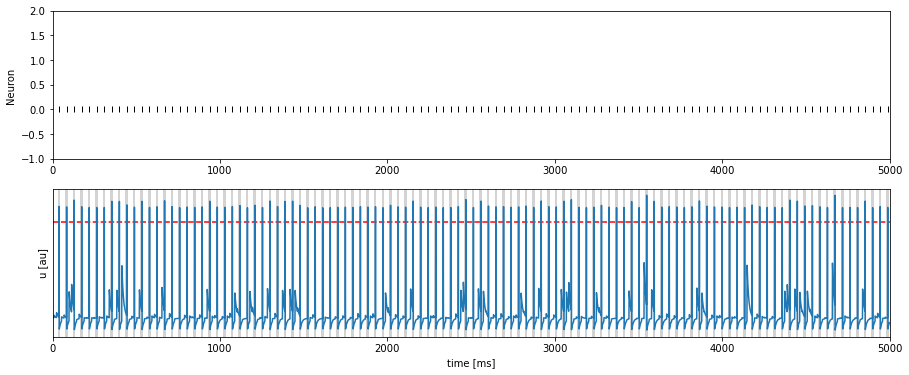

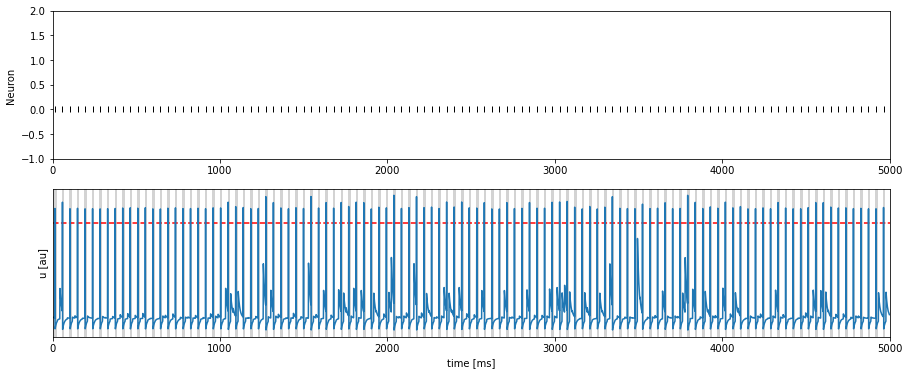

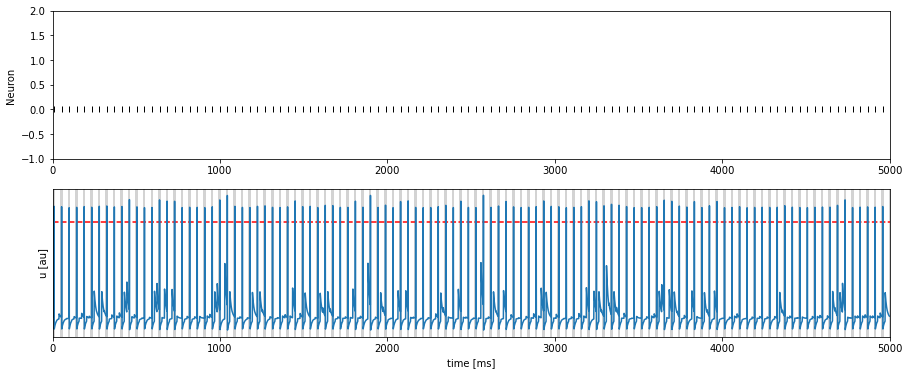

(<AxesSubplot:ylabel='Neuron '>,
 <AxesSubplot:xlabel='time [ms]', ylabel='u [au]'>)

In [9]:
pat_times = np.load('./sequences/all_nums/pat_test_all_nums.npy')
Sin_tmp = torch.load('../cleanDSNN/results/old_results/all_nums/layer_5_conv.pt')
T = Sin_tmp.shape[0]
N_out = 1
N_in = Sin_tmp.shape[1]
th = 3.5

singleNeuron = STDPLIFDensePopulation(in_channels=N_in, out_channels=N_out,
                                        weight=0.75, alpha=float(np.exp(-1e-3/10e-3)),
                                        beta=float(np.exp(-1e-3/2e-5)), delay=0,
                                        th=th, a_plus=.03125, a_minus=.045625,
                                        w_max=1.)
Sin = Sin_tmp.clone().detach()

# Realizamos el entrenamiento STDP
Uprobe = np.empty([T, N_out])
Iprobe = np.empty([T, N_out])
Sprobe = np.empty([T, N_out])
for n in range(T):
    state = singleNeuron.forward_no_learning(Sin[n].unsqueeze(0))
    Uprobe[n] = state.U.data.numpy()
    Iprobe[n] = state.I.data.numpy()
    Sprobe[n] = state.S.data.numpy()
    
sv_utils.plotLIF(U=Uprobe[0:5000], S=Sprobe[0:5000], pat_times=pat_times[0:5000], th=th)
sv_utils.plotLIF(U=Uprobe[25000:30000], S=Sprobe[25000:30000], pat_times=pat_times[20000:25000], th=th)
sv_utils.plotLIF(U=Uprobe[30000:35000], S=Sprobe[30000:35000], pat_times=pat_times[30000:35000], th=th)